Reference Source:

https://daniel-furman.github.io/Python-species-distribution-modeling/

In [21]:
import os 
# os.mkdir("inputs")
# os.mkdir("outputs")

import sys
# %pip install geopandas
# %pip install pyimpute

In [4]:
import geopandas as gpd
import shutil
import glob
# grab jtree data after cloning Git repo
for f in sorted(glob.glob('data/Rhinella_marina/rhi_mar*')):
    shutil.copy(f,'inputs/')
# or grab your data of choice and move to 'inputs/'
pa = gpd.GeoDataFrame.from_file("data/Rhinella_marina/rhi_mar.shp")
pa.sample(5) # GeoDataFrame for the species


,CLASS,geometry
40887,0.0,POINT (119.77083 52.81250)
22796,0.0,POINT (-69.35417 -7.64583)
24870,1.0,POINT (143.27419 -14.84865)
10631,0.0,POINT (39.27083 32.39583)
53106,1.0,POINT (152.84644 -26.29506)


In [6]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: GEOGCS["GCS_unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
65325 observations with 2 columns


We can map the species presences (pa==1).

<AxesSubplot:>

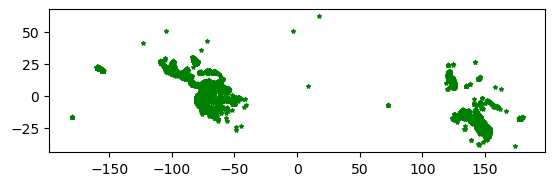

In [7]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=8)


And we can map the background points (pa == 0).

<AxesSubplot:>

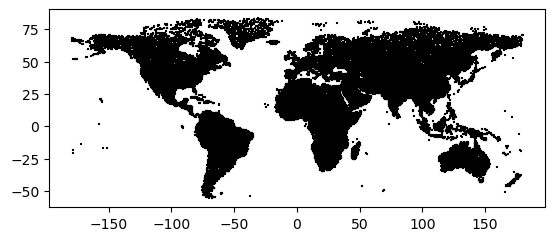

In [24]:
import matplotlib.pyplot as plt

pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=4)


First, we load 19 bioclimatic features (here we use 2.5 arc-minute resolution) from the publicly available WorldClim database (v. 2.1, Fick & Hijmans, 2017).



In [10]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/Rhinella_marina/bclim*.asc')):
    shutil.copy(f,'inputs/')
raster_features = sorted(glob.glob(
    'inputs/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 19 raster features.


We are now ready to use pyimpute to generate the raster maps of suitability. We first prep the pyimpute workflow:

In [29]:
import time
start_time = time.time()

# Your function call
load_training_vector()

print(f"Execution time: {time.time() - start_time} seconds")


TypeError: load_training_vector() missing 3 required positional arguments: 'response_shapes', 'explanatory_rasters', and 'response_field'

In [28]:
pa_30 = pa.head(30)
# type(pa)

type(pa_30)

train_xs, train_y = load_training_vector(pa_30, raster_features, response_field='CLASS')



KeyboardInterrupt: 

In [ ]:
target_xs, raster_info = load_targets(raster_features)

In [15]:
from pyimpute import load_training_vector
from pyimpute import load_targets
train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')


KeyboardInterrupt: 

In [20]:
target_xs, raster_info = load_targets(raster_features)

In [ ]:
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

In [ ]:
# import machine learning classifiers
import xgboost
import lightgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier())
    }

from pyimpute import impute
from sklearn import model_selection
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('outputs/' + name + '-images')
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images',
           class_prob=True, certainty=True)


ModuleNotFoundError: No module named 'xgboost'

All done! We have a responses.tif raster which is the predicted class (0 or 1) and probability_1.tif with a continuous suitability scale. Let's average the continuous output for the four models and plot our map.

In [ ]:
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

import rasterio
distr_rf = rasterio.open("outputs/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Toad Cane Range, averaged", cmap="Greens")

Zooming in specific map


In [ ]:
plotit(distr_averaged[100:150, 100:150], "Joshua Tree National Park Suitability", cmap="Greens")